In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 데이터 불러오기

In [2]:
data_raw = pd.read_csv("./csvfiles/체질검사.csv")

In [3]:
data_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


# 파운드, 인치 -> KG, CM로 변환

In [4]:
data = data_raw.assign(WEIGHT_KG = data_raw["WEIGHT"]*0.45)
data = data.assign(HEIGHT_CM = data_raw["HEIGHT"]*2.54)

In [5]:
data = data.drop(['WEIGHT', 'HEIGHT'], axis = 1)

In [6]:
data.head()

,FAT,AGE,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,WEIGHT_KG,HEIGHT_CM
0,35.2,46,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,163.4175,183.515
1,11.8,27,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,75.6000,180.975
2,22.2,69,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,79.9875,173.990
3,10.6,57,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,66.4875,167.005
4,47.5,51,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,98.5500,162.560


# 파생변수 BMI 만들기

#### 몸무게 / 키(m) * 키(m)

In [8]:
data["BMI"] = data["WEIGHT_KG"] / ((data["HEIGHT_CM"]*0.01) * (data["HEIGHT_CM"]*0.01))

In [9]:
data.head()

,FAT,AGE,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,WEIGHT_KG,HEIGHT_CM,BMI
0,35.2,46,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,163.4175,183.515,48.523870
1,11.8,27,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,75.6000,180.975,23.082595
2,22.2,69,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,79.9875,173.990,26.422478
3,10.6,57,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,66.4875,167.005,23.838617
4,47.5,51,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,98.5500,162.560,37.293165


# 회귀 모델 시작

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import scale
import statsmodels.api as sm

In [11]:
x = data.drop(['FAT'], axis=1)
y = data["FAT"]

In [12]:
print(x.shape)
print(y.shape)

(252, 14)
(252,)


In [13]:
# 절편 추가
x_const = sm.add_constant(x)
x_const.head()

/home/pirl/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,AGE,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,WEIGHT_KG,HEIGHT_CM,BMI
0,1.0,46,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,163.4175,183.515,48.523870
1,1.0,27,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,75.6000,180.975,23.082595
2,1.0,69,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,79.9875,173.990,26.422478
3,1.0,57,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,66.4875,167.005,23.838617
4,1.0,51,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,98.5500,162.560,37.293165


# 기본 회귀 모델

In [14]:
# 회귀 모델 생성
reg_multi_model = sm.OLS(y, x_const)
#적합
reg_multi_results = reg_multi_model.fit()
print(reg_multi_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     50.56
Date:                Sun, 10 Feb 2019   Prob (F-statistic):           5.49e-63
Time:                        20:54:05   Log-Likelihood:                -718.19
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     237   BIC:                             1519.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24.2460     24.500     -0.990      0.3

In [15]:
ds_vif = pd.DataFrame()
ds_vif['variable'] = x_const.columns
ds_vif["VIF"] = [variance_inflation_factor(x_const.values, i) for i in range(x_const.shape[1])]
ds_vif.sort_values("VIF", inplace=True)
ds_vif.round(3)

,variable,VIF
8,ANKLE,1.922
10,FOREARM,2.196
1,AGE,2.251
11,WRIST,3.378
9,BICEPS,3.674
2,NECK,4.456
7,KNEE,4.815
14,BMI,7.432
6,THIGH,8.010
13,HEIGHT_CM,9.146


#### WEIGHT_KG의 VIF가 굉장히 높으므로 x변수에서 제외

In [16]:
x = x.drop(["WEIGHT_KG"],axis = 1)

In [17]:
# 다시 절편 추가
x_const = sm.add_constant(x)
x_const.head()

,const,AGE,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,HEIGHT_CM,BMI
0,1.0,46,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,183.515,48.523870
1,1.0,27,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,180.975,23.082595
2,1.0,69,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,173.990,26.422478
3,1.0,57,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,167.005,23.838617
4,1.0,51,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,162.560,37.293165


In [18]:
x.head()

,AGE,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,HEIGHT_CM,BMI
0,46,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,183.515,48.523870
1,27,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,180.975,23.082595
2,69,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,173.990,26.422478
3,57,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,167.005,23.838617
4,51,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,162.560,37.293165


#### Weight 제외 후 다시 VIF 확인

In [19]:
ds_vif = pd.DataFrame()
ds_vif['variable'] = x_const.columns
ds_vif["VIF"] = [variance_inflation_factor(x_const.values, i) for i in range(x_const.shape[1])]
ds_vif.sort_values("VIF", inplace=True)
ds_vif.round(3)

,variable,VIF
8,ANKLE,1.847
10,FOREARM,2.196
1,AGE,2.196
11,WRIST,3.327
9,BICEPS,3.507
2,NECK,3.962
12,HEIGHT_CM,4.665
13,BMI,4.729
7,KNEE,4.788
6,THIGH,7.837


#### feature들의 VIF들이 괜찮아 보임 회귀 분석 다시 진행

# VIF로 변수(WEIGHT)제거 후 회귀 모델

In [20]:
# 회귀 모델 생성
reg_multi_model = sm.OLS(y, x_const)
#적합
reg_multi_results = reg_multi_model.fit()
print(reg_multi_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     53.97
Date:                Sun, 10 Feb 2019   Prob (F-statistic):           2.29e-63
Time:                        20:54:05   Log-Likelihood:                -719.42
No. Observations:                 252   AIC:                             1467.
Df Residuals:                     238   BIC:                             1516.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6651      8.839      1.207      0.2

#### P-value가 더 내려가고 모델의 정규성이 더 높아진 것을 확인할 수 있음

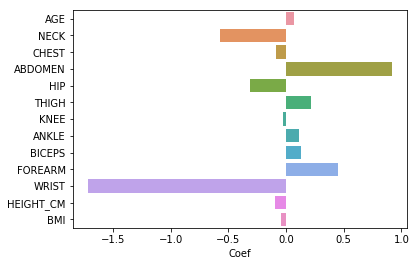

In [21]:
ds_reg_coef = pd.DataFrame({"Coef":reg_multi_results.params.values[1:]},
                           index=reg_multi_model.exog_names[1:])

# ds_reg_coef.plot.barh(y='Coef', legend = True, )
sns.barplot(data=ds_reg_coef, x = 'Coef', y =ds_reg_coef.index)

#### 표준화 하기

In [22]:
x_scaled = scale(x_const)

/home/pirl/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


# 표준화 후 회귀 모델

In [23]:
# 회귀 모델 생성
reg_multi_model = sm.OLS(y, x_const)
#적합
reg_multi_results = reg_multi_model.fit()
print(reg_multi_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     53.97
Date:                Sun, 10 Feb 2019   Prob (F-statistic):           2.29e-63
Time:                        20:54:06   Log-Likelihood:                -719.42
No. Observations:                 252   AIC:                             1467.
Df Residuals:                     238   BIC:                             1516.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6651      8.839      1.207      0.2

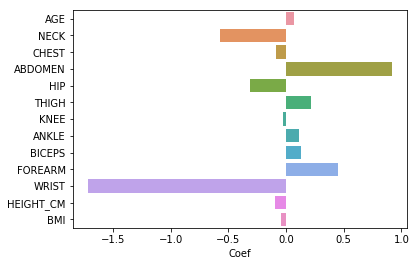

In [24]:
ds_reg_coef = pd.DataFrame({"Coef":reg_multi_results.params.values[1:]},
                           index=reg_multi_model.exog_names[1:])

# ds_reg_coef.plot.barh(y='Coef', legend = True, )
sns.barplot(data=ds_reg_coef, x = 'Coef', y =ds_reg_coef.index)

# 후진제거법 사용해보기

In [25]:
model = LinearRegression()
rfe = RFE(estimator= model, n_features_to_select=5).fit(x_const, y)

#선택된 변수
selected_cols = x_const.columns[rfe.support_].tolist()
removed_cols = x_const.columns[~rfe.support_].tolist()

print("Selected features:{}".format(selected_cols))
print("Removed features:{}".format(removed_cols))      

Selected features:['NECK', 'ABDOMEN', 'HIP', 'FOREARM', 'WRIST']
Removed features:['const', 'AGE', 'CHEST', 'THIGH', 'KNEE', 'ANKLE', 'BICEPS', 'HEIGHT_CM', 'BMI']


In [29]:
# 후진 제거 후 선택된 features로 회귀 모델 생성
x_const_rfe = sm.add_constant(x[selected_cols])
reg_multi_model = sm.OLS(y, x_const[selected_cols])
reg_multi_results = reg_multi_model.fit()
print(reg_multi_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     1100.
Date:                Sun, 10 Feb 2019   Prob (F-statistic):          1.65e-166
Time:                        20:56:02   Log-Likelihood:                -727.02
No. Observations:                 252   AIC:                             1464.
Df Residuals:                     247   BIC:                             1482.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
NECK          -0.5884      0.212     -2.769      0.0

/home/pirl/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


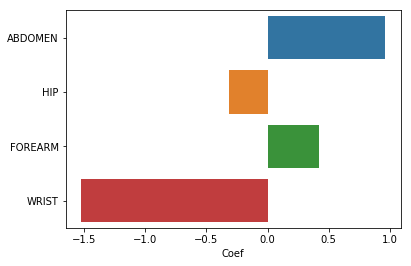

In [30]:
ds_reg_coef = pd.DataFrame({"Coef":reg_multi_results.params.values[1:]},
                           index=reg_multi_model.exog_names[1:])

# ds_reg_coef.plot.barh(y='Coef', legend = True, )
sns.barplot(data=ds_reg_coef, x = 'Coef', y =ds_reg_coef.index)

# 해석
* 파생변수(BMI)를 만들어 회귀 모델의 설명력을 높이려 했지만 효과가 있지 않았다.
* 후진선택법을 이용해 고른 변수들보다 VIF를 통해 변수제거한 회귀 모델을 만들자 adj R square가 0.726 -> 0.733 으로 가장 높았다.
* 이는 데이터 목표 변수와 연관되지 않은 파생변수를 만들어봤자 모델 설명력에 전혀 도움이 되지 않는다는 것을 알 수 있었다.
* 적절한 파생변수를 만들기 위해서는 데이터의 도메인 지식을 공부해야하는 필요성을 다시 깨닫게 되었다.

